The generated images below may slightly differ from those in the paper, but this does not impact our main conclusions. The discrepancy is primarily due to differences in the sorting of items with the same count by the value_counts function.

In [ ]:
import os
import sys
from pathlib import Path

# Set root and data directories
ROOT_DIR = Path(os.getcwd()).resolve().parent.parent
sys.path.insert(0, str(ROOT_DIR))
from path import DATA_DIR

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)

# Set plot directory
os.chdir(DATA_DIR / f"result_2025/down_stream_analysis")



ROOT_DIR: /root/project/reproducity
DATA_DIR: /data/sequential_data


In [5]:
import pickle
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use("Agg")

mpl.rcParams.update({
    "axes.labelsize": 7,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "legend.frameon": False,
    "legend.fontsize": 3,
    "axes.linewidth": 0.5,
    "pdf.fonttype": 42,
    "figure.dpi": 300,
})
%matplotlib inline


## 1. Read and processes pathway data
pathway data for multiple cell lines and computes statistics for the top 10 most frequent pathways in each class. 

In [6]:
# 1. Data preparation
all_ccls = ["A375", 'MDAMB231', 'SKBR3', 'MCF7', 'HS578T', 'BT20','HEPG2','HCC515','A549', 'HUH7']
total_key_pathway_df = []
all_class_labels = []

for cell_line in all_ccls:
    # Load class labels
    class_label_file_name = f"cluster_label_res/{cell_line}.pkl"
    with open(class_label_file_name, "rb") as f:
        class_labels, _ = pickle.load(f)
    
    # Load pathway results
    key_pathway_file_name = f"key_pathway_res/{cell_line}.pkl"
    with open(key_pathway_file_name, "rb") as f:
        key_pathway_ls = pickle.load(f)

    key_pathway_arr = np.array(key_pathway_ls, dtype=object)

    # Find an empty DataFrame as placeholder
    for item in key_pathway_arr:
        if isinstance(item, pd.DataFrame) and item.shape[0] == 0:
            null_df = item
            break
            
    new_class_labels = []
    new_key_pathway_arr = []
    for i, item in enumerate(key_pathway_arr):
        if isinstance(item, list):
            new_key_pathway_arr.append(null_df)
        else:
            new_key_pathway_arr.append(item)
            new_class_labels.extend([class_labels[i]] * item.shape[0])
    
    key_pathway_df = pd.concat(new_key_pathway_arr)
    key_pathway_df["class"] = new_class_labels
    total_key_pathway_df.append(key_pathway_df)
    all_class_labels.append(class_labels)
    
# Merge all dataframes
total_key_pathway_df = pd.concat(total_key_pathway_df)

# Count occurrences of each class label
keys, vals = np.unique(np.concatenate(all_class_labels), return_counts=True)
class_stats = dict(zip(keys, vals))

# Collect top pathway statistics for each class
all_res = []
cluster_numbers = 7
for i in range(1, cluster_numbers+1):
    # For each class
    class_key_pathway_df = total_key_pathway_df[total_key_pathway_df["class"] == i]
    pathways, cnts = np.unique(class_key_pathway_df.index, return_counts=True)
    pathway_stats = pd.DataFrame({"pathway": pathways, "count": cnts}).sort_values("count", ascending=False, kind="stable")
    
    # Select top N pathways
    N = 10
    pathway_stats = pathway_stats.iloc[:N, :]
    pathway_stats["class"] = f"class{i}"
    pathway_stats["freq"] = pathway_stats["count"] * 100 / class_stats[i]
    pathway_stats["rank"] = np.arange(N, 0, -1)
    
    all_res.append(pathway_stats)

# Merge results
all_res = pd.concat(all_res)


/tmp/ipykernel_637933/678477379.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  key_pathway_df = pd.concat(new_key_pathway_arr)
/tmp/ipykernel_637933/678477379.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  key_pathway_df = pd.concat(new_key_pathway_arr)
/tmp/ipykernel_637933/678477379.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the re

In [7]:
all_res

,pathway,count,class,freq,rank
0,NaN,NaN,NaN,NaN,10
1,NaN,NaN,NaN,NaN,9
2,NaN,NaN,NaN,NaN,8
3,NaN,NaN,NaN,NaN,7
4,NaN,NaN,NaN,NaN,6
...,...,...,...,...,...
5,NaN,NaN,NaN,NaN,5
6,NaN,NaN,NaN,NaN,4
7,NaN,NaN,NaN,NaN,3
8,NaN,NaN,NaN,NaN,2


## 2. Create plot data

In [8]:
import re

def process_string(input_str, len_thre=20):
    if len(input_str) <= len_thre:
        return input_str

    words = re.findall(r'\S+', input_str)
    result, line, length = [], [], 0

    for word in words:
        if length + len(word) <= len_thre:
            line.append(word)
            length += len(word) + 1
        else:
            result.append(" ".join(line))
            line, length = [word], len(word) + 1

    if line:
        result.append(" ".join(line))

    return "\n".join(result)




In [9]:
# Count occurrences of each pathway
pathway_counts = all_res["pathway"].value_counts()
pathway_keys, pathway_vals = pathway_counts.index, pathway_counts.values
top_n = len(pathway_keys)

# Create mapping dictionaries for pathway and class
pathway_dict = {key: rank for key, rank in zip(pathway_keys, range(top_n, 0, -1))}  # for y axis plot
class_dict = {f"class{i}": i for i in range(1, cluster_numbers+1)}  # for x axis plot

# Process pathway names (e.g., formatting for visualization)
pathway_names = [process_string(p) for p in pathway_keys]

# Initialize arrays for scatter plot data
x_arr, y_arr, val_arr, pair_arr, color_arr = [], [], [], [], []

# Iterate through all_res to gather scatter plot data
for _, row in all_res.iterrows():
    pathway, class_label, freq, color = row["pathway"], row["class"], row["freq"], row["rank"]
    if pathway in pathway_dict:
        x, y = class_dict[class_label], pathway_dict[pathway]
        x_arr.append(x)
        y_arr.append(y)
        pair_arr.append((x, y))
        val_arr.append(freq)
        color_arr.append(color)

# Normalize val_arr values for point size
val_arr_norm = (val_arr / np.max(val_arr)).tolist()

# Add missing (x, y) pairs with small default points
zero_val, zero_color = 0.001, 0
for x in range(1, len(class_dict) + 1):
    for y in range(1, top_n + 1):
        if (x, y) not in pair_arr:
            x_arr.append(x)
            y_arr.append(y)
            val_arr_norm.append(zero_val)
            color_arr.append(zero_color)


## 3. Plot

In [10]:
# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(6, 6), gridspec_kw={'width_ratios': [2, 1.5, 1]})

# ======= 1. Scatter plot (Bubble Heatmap) =======
scatter = axes[0].scatter(
    x_arr, y_arr, alpha=0.5, sizes=np.array(val_arr_norm) * 90, 
    edgecolors="#323232", linewidths=0.5, c=color_arr, cmap="Reds"
)

# X-axis settings
axes[0].set_xticks(np.arange(1, 8))
axes[0].set_xticklabels(list(class_dict.keys()), rotation=45, ha='right')
axes[0].tick_params(axis='x', direction='out', length=1)

# Y-axis settings
axes[0].set_ylim([0.5, top_n + 0.8])
axes[0].set_yticks(np.arange(1, top_n + 1))
axes[0].yaxis.tick_right()
axes[0].set_yticklabels([" "] * top_n)
axes[0].tick_params(axis='y', direction='out', length=1)

axes[0].set_title("Pathway-associated tumor state transitions", fontsize=7)

# Add grid lines
for i in range(1, len(class_dict) + 1):
    axes[0].axvline(x=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)
for i in range(top_n + 1):
    axes[0].axhline(y=i, color='grey', linestyle='-', linewidth=0.5, alpha=0.2)

# ======= 2. Color and Size Legends =======
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].get_xaxis().set_visible(False)

# Add colorbar
cax = fig.add_axes([1, 0.5, 0.02, 0.2])
cbar = plt.colorbar(scatter, ax=axes[0], cax=cax)
cbar.set_label('color_arr')

# Add size legend
legend_sizes = [90, 45, 9]
legend_labels = ['1.0', '0.5', '0.1']
scatter_legend = [
    axes[1].scatter([], [], s=size, label=label, edgecolors="#323232", linewidths=0.5, color='black')
    for size, label in zip(legend_sizes, legend_labels)
]
axes[1].legend(handles=scatter_legend, title='', bbox_to_anchor=(2.35, 0.95), loc='center right')

# ======= 3. Horizontal Bar Chart (Pathway Count) =======
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[2].barh(np.arange(top_n, 0, -1), pathway_vals, align="center", color='#ED8072')

# Y-axis settings
axes[1].set_ylim([0.5, top_n + 0.8])
axes[1].set_yticks(np.arange(1, top_n + 1))
axes[1].set_yticklabels(pathway_keys[::-1], ha="left")
axes[1].tick_params(axis='y', direction='out', length=0)

# X and Y axis settings for the bar chart
axes[2].set_ylim([0.5, top_n + 0.8])
axes[2].set_yticks(np.arange(1, top_n + 1))
axes[2].set_yticklabels([" "] * top_n)
axes[2].tick_params(axis='y', direction='out', length=1)

axes[2].set_xticks([0, 2])
axes[2].tick_params(axis='x', direction='out', length=1)
axes[2].set_title("Count", fontsize=7)


Text(0.5, 1.0, 'Count')

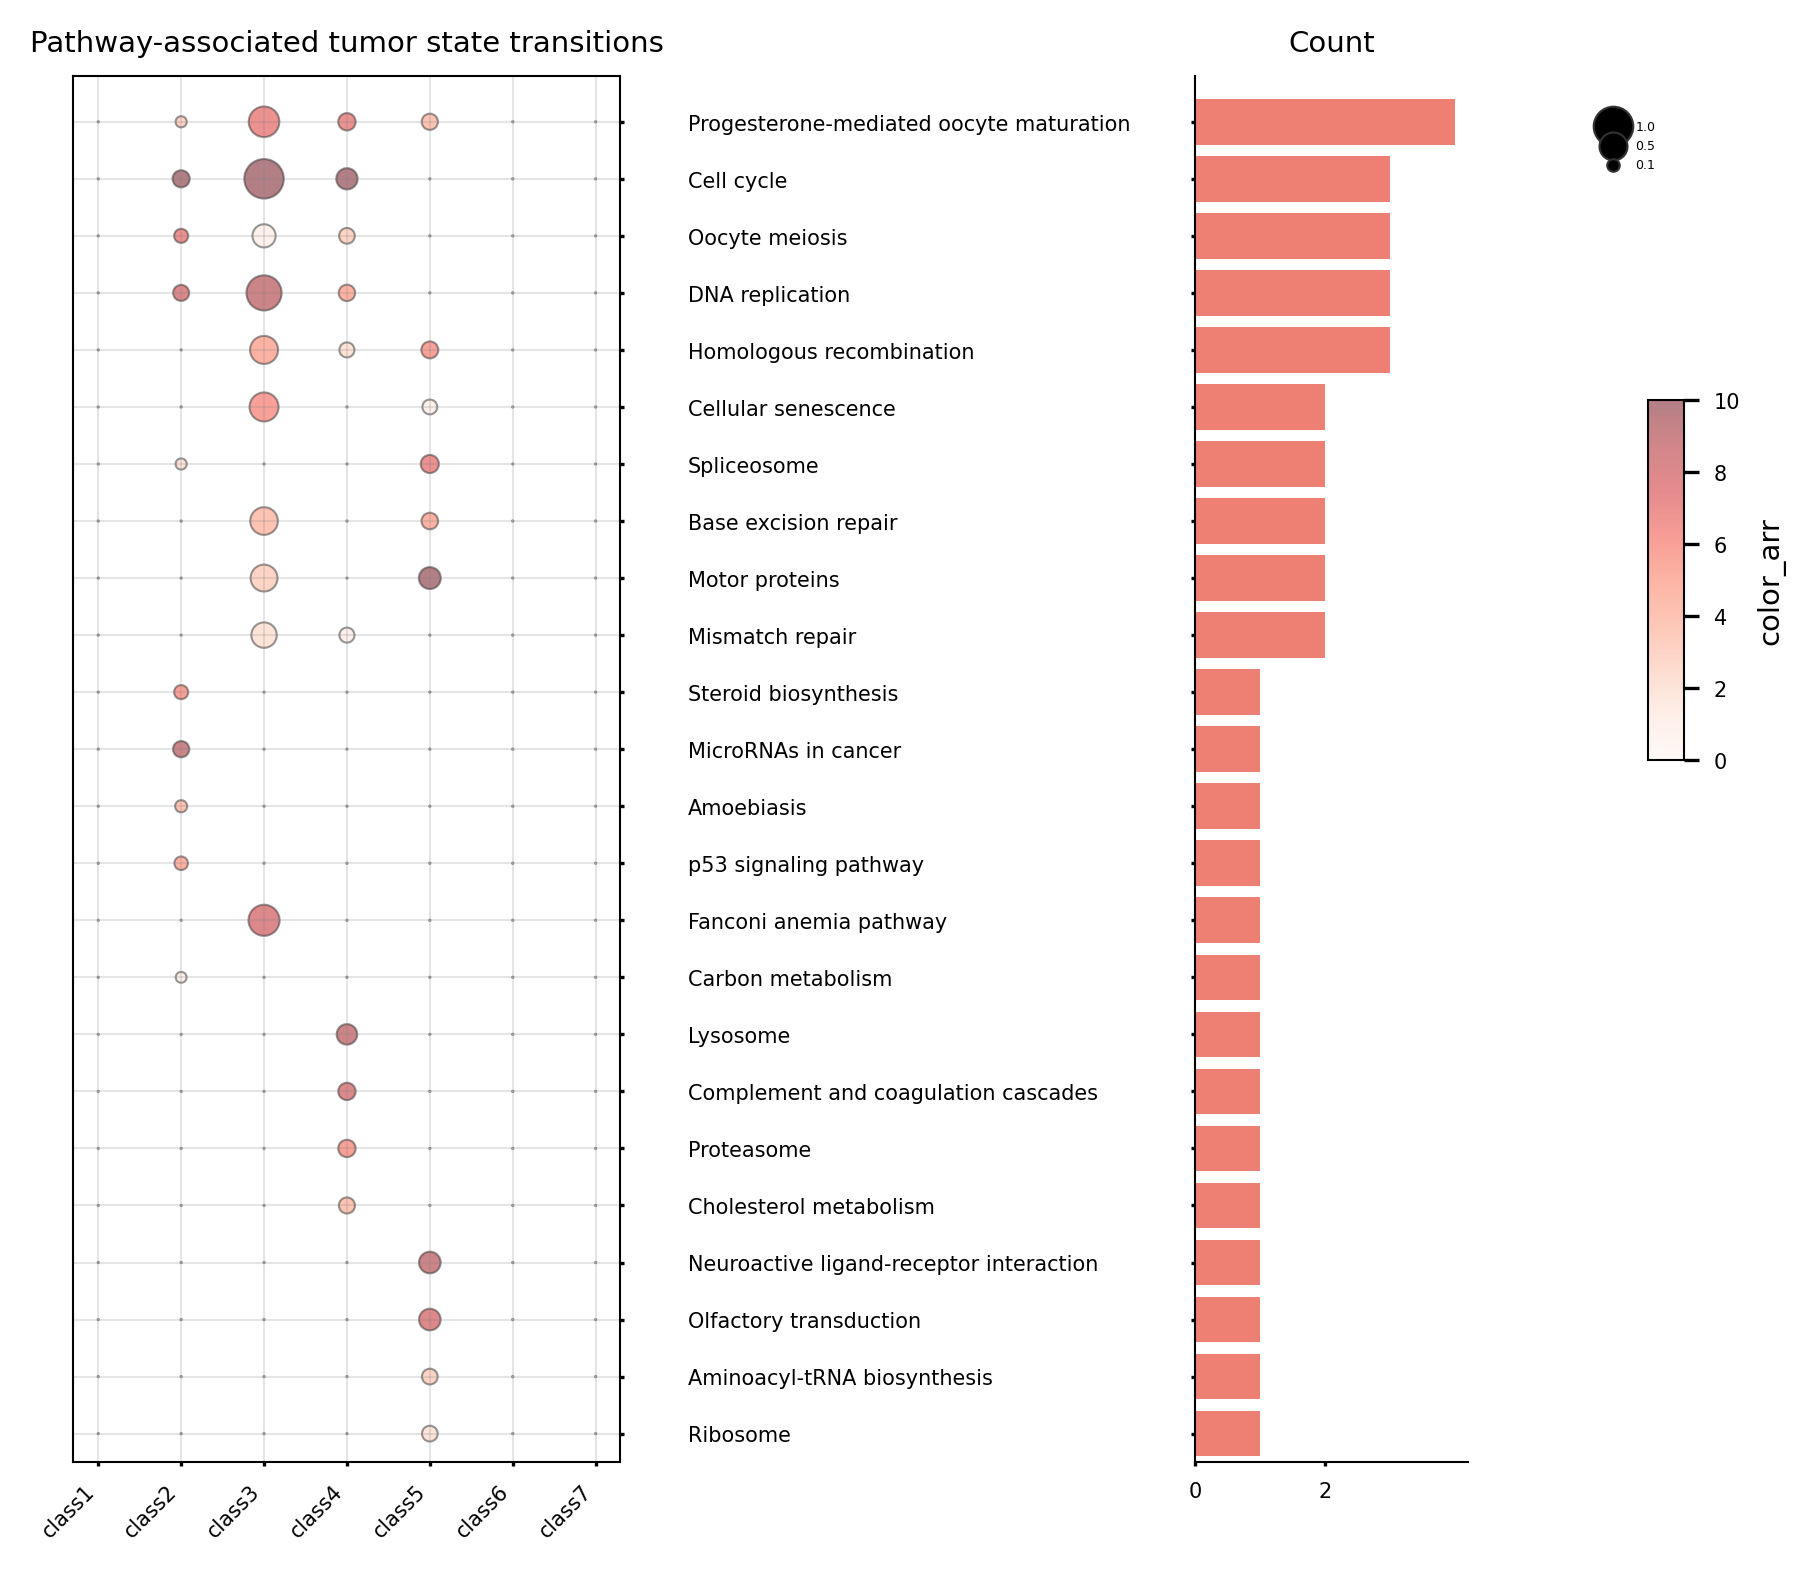

In [11]:
plt.show()